In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from imports import *
from torch_imports import *
from plots import *

# Data Collection/Cleaning/Preprocessing

## Imports
- Given OHLC, we're going to be predicting the closing prices

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


## Understand the data

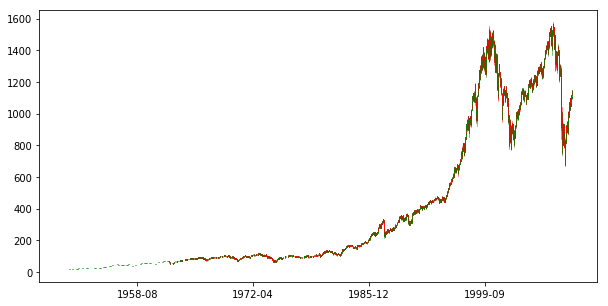

In [20]:
plot_ohlc(df)

## Missing Values

In [ ]:
plot_missing_in_features(df)

no missing values in any features

## Features

Besides date, everything is ordinal

## Split
- Option 1: Use 25% of last training data as validation set
- Option 2: Use the same length of time period as the test case uses 
- Sorta Option 3: sorta like kfold cross val. but a nested cv for sure
    - https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

In [177]:
# For now use Option 1
trn_size = len(df) - int(.10 * len(df))
val_idx = range(trn_size, len(df))     # get tail end of df
trn_idx = range(trn_size)
val = df.iloc[val_idx,]
trn = df.iloc[trn_idx,]
print(len(trn), len(val))
# dropping Date just for neural networks
# trn_X = trn.drop(['Date','Close'],axis=1)
# trn_y = trn['Close']
# val_X = val.drop(['Date', 'Close'],axis=1)
val_y = val['Close']

13594 1510


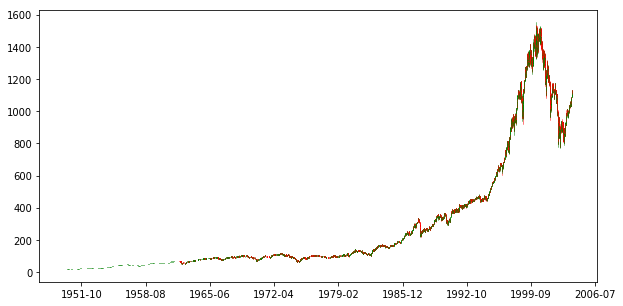

In [178]:
plot_ohlc(trn)

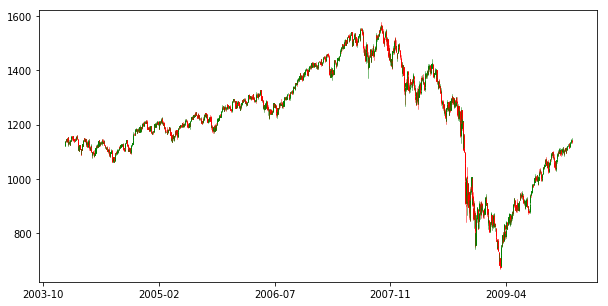

In [179]:
plot_ohlc(val)

## Standardize and normalize

- Since its NN should use batchnorm
- don't forget to standardize and normalize test data with same mapper

In [24]:
# # Normalize range to 0-1
# from sklearn.preprocessing import MinMaxScaler
# trn_norm_data = trn_X.copy()
# val_norm_data = val_X.copy()
# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = scaler.fit(trn_norm_data)
# trn_norm_X = scaler.transform(trn_norm_data)
# val_norm_X = scaler.transform(val_norm_data)

In [25]:
# # Standardize
# from sklearn.preprocessing import StandardScaler
# norm_data = trn_X.copy()
# scaler = StandardScaler()
# scaler = scaler.fit(norm_data)
# norm_data = scaler.transform(norm_data)

# Custom Dataset for Dataloader

In [6]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        y = y.astype(np.float32)
        self.y = y[:, np.newaxis]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

# Train

In [7]:
from sklearn.preprocessing import StandardScaler

## Train

In [276]:
class Trainer():
    def __init__(self, md, live_plot=False):
        (self.trn_dl, self.val_dl) = md.data
        self.liveplot = None
        self.final_preds = dict()  # key is epoch, and value is the epoch's preds
#         if plot: 
#             %matplotlib notebook
#             self.liveplot = LivePlotNotebook()    no live plot yet
        
    def train(self, model, n_epochs, opt, crit, mom=0.98, plot_result=False):
        avg_mom = mom
        avg_loss = 0
        trn_loss, val_loss = [], []
        epoch_trn_loss, epoch_val_loss = 0,0 
        model_stepper = Stepper(model, opt, crit)
        b = False
        for epoch in tnrange(n_epochs, desc="Training"):
            batch_num = 0
            model_stepper.reset(True) # turns training attribute on 
            t = tqdm(iter(self.trn_dl), leave=False, total=len(self.trn_dl), miniters=0)
            for (X, y) in t:
                batch_num += 1
                loss = model_stepper.step(X, y, epoch)
                avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
                debias_loss = avg_loss / (1 - avg_mom**batch_num)
                t.set_postfix(loss=debias_loss, refresh=False)
                t.set_description("Epoch " + str(epoch + 1))
                epoch_trn_loss = debias_loss
            trn_loss.append(debias_loss)

            self.final_preds[epoch + 1], batch_cnts, batch_losses = np.asarray([]), [], []
            with torch.no_grad():
                t = tqdm(iter(self.val_dl), leave=False, total=(len(self.val_dl)), miniters=0)
                for (X,y) in t:
                    preds, loss = model_stepper.evaluate(X, y)
                    self.final_preds[epoch+1] = np.append(self.final_preds[epoch+1], to_np(preds).flatten())
                    batch_cnts.append(X[0].shape[0])  # append the batch size
                    batch_losses.append(loss)
                    epoch_val_loss = loss
                    
                val_loss.append(np.average(batch_losses, 0, weights=batch_cnts))
            print("Epoch [{}/{}], MSE Train Loss: {:.4f}, MSE Val Loss: {:.4f}"
                  .format(epoch+1, n_epochs, epoch_trn_loss , epoch_val_loss))
        if plot_result:
            plt.plot(trn_loss)
            plt.plot(val_loss)
            plt.legend(['Train', 'Val'], loc="upper right")
            plt.show()
        return self.final_preds


## Simpler Train

In [251]:
# class Trainer():
#     def __init__(self, md, live_plot=False):
#         (self.trn_dl, self.val_dl) = md.data
#         self.final_preds = dict()  # key is epoch, and value is the epoch's preds
        
#     def train(self, model, n_epochs, opt, crit, mom=0.98, plot_result=False):
#         avg_mom = mom
#         avg_loss = 0
#         trn_loss, val_loss = [], []    # losses at the end of each epoch
#         epoch_trn_loss, epoch_val_loss = 0,0 
#         for epoch in tnrange(n_epochs, desc="Training"):
#             batch_num = 0
#             current_loss = 0
#             t = tqdm(iter(self.trn_dl), leave=False, total=len(self.trn_dl), miniters=0)
#             for (X, y) in t:
#                 batch_num += 1
#                 opt.zero_grad()
#                 output = model(X)
#                 loss = crit(output, y)
#                 loss.backward()
#                 opt.step()
#                 t.set_postfix(loss=loss, refresh=False)
#                 t.set_description("Epoch " + str(epoch + 1))
#                 epoch_trn_loss = loss
#             trn_loss.append(epoch_trn_loss)

#             self.final_preds[epoch + 1], batch_cnts= np.asarray([]), []
#             with torch.no_grad():
#                 t = tqdm(iter(self.val_dl), leave=False, total=(len(self.val_dl)), miniters=0)
#                 for (X,y) in t:
#                     preds = model(X)
#                     loss = crit(preds, y)
#                     self.final_preds[epoch+1] = np.append(self.final_preds[epoch+1], to_np(preds).flatten())
#                     batch_cnts.append(X[0].shape[0])  # append the batch size
#                     epoch_val_loss = loss
#                 val_loss.append(epoch_val_loss)
        
#             print("Epoch [{}/{}], MSE Train Loss: {:.4f}, MSE Val Loss: {:.4f}" 
#                   .format(epoch+1, n_epochs, epoch_trn_loss , epoch_val_loss))
#         if plot_result:
#             plt.plot(trn_loss)
#             plt.plot(val_loss)
#             plt.legend(['Train', 'Val'], loc="upper right")
#             plt.show()
# #             print("Epoch [{}/{}], MSE Train Loss: {:.4f}, MSE Val Loss: {:.4f}"
# #                   .format(epoch+1, n_epochs, trn_loss , val_loss))
#         return self.final_preds


# Trying different networks

## One Layer Neural Network

Epoch [1/10], MSE Train Loss: 365.1201, MSE Val Loss: 23018.2988


Epoch [2/10], MSE Train Loss: 264.9953, MSE Val Loss: 1478.2991


Epoch [3/10], MSE Train Loss: 256.7837, MSE Val Loss: 8314.8779


Epoch [4/10], MSE Train Loss: 262.4250, MSE Val Loss: 6902.7441


Epoch [5/10], MSE Train Loss: 255.8339, MSE Val Loss: 1858.1592


Epoch [6/10], MSE Train Loss: 263.1237, MSE Val Loss: 5501.2324


Epoch [7/10], MSE Train Loss: 249.2500, MSE Val Loss: 12790.5605


Epoch [8/10], MSE Train Loss: 253.2347, MSE Val Loss: 425.6439


Epoch [9/10], MSE Train Loss: 252.7519, MSE Val Loss: 13476.7295


Epoch [10/10], MSE Train Loss: 251.1108, MSE Val Loss: 5223.8706


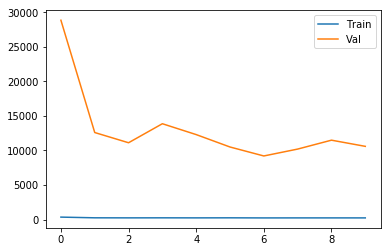

In [281]:
# %matplotlib notebook
from networks import *
from imports import *
from torch_imports import *

if __name__ == '__main__':
    md = ModelData(trn=trn, val=val, y='Close', drop=['Date'], ds=StockDataset, op=StandardScaler())
    md.makeDataLoaders(bs=32, shuffle=True, num_workers=0)
    model = OneLayerNeuralNetwork(input_size=5, output_size=1)
    opt = optim.SGD(model.parameters(), lr=.01, weight_decay = 0.1)
    NN1_trainer = Trainer(md)
    preds = NN1_trainer.train(model, n_epochs=10, opt=opt, crit=F.mse_loss, plot_result=True)

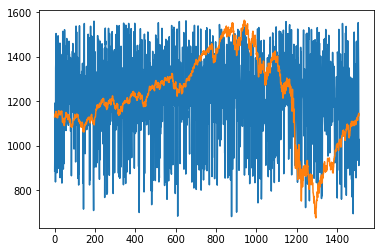

In [279]:
plt.plot(preds[6])
plt.plot(val_y.values[:3000])

## Two Layer Neural Network

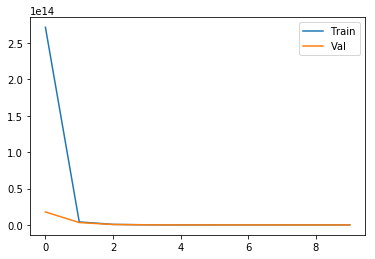

In [258]:
from imports import *
from torch_imports import *
from networks import *
if __name__ == '__main__':
    md = ModelData(trn=trn, val=val, y='Close', drop=['Date'], ds=StockDataset, op=StandardScaler())
    md.makeDataLoaders(bs=32, shuffle=True, num_workers=0)
    
    model = TwoLayerNeuralNetwork(input_size=5, layer1_size=32, layer2_size=16, output_size=1)
    opt = optim.SGD(model.parameters(), lr=.001)
    
    NN1_trainer = Trainer(md)
    preds = NN1_trainer.train(model, n_epochs=10, opt=opt, crit=F.mse_loss, plot_result=True)

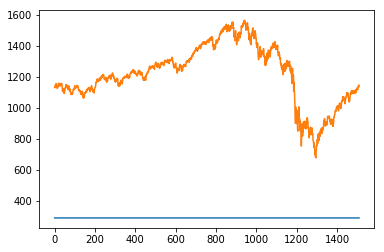

In [186]:
plt.plot(preds[9])
plt.plot(val_y.values)

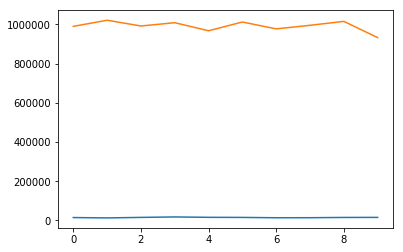

In [174]:
plt.plot(trn_loss)
plt.plot(val_loss)

# ~~LivePlot~~

In [ ]:
# class LivePlotNotebook(object):
#     """
#     Live plot using %matplotlib notebook in jupyter notebook
    
#     Usage:
#     ```
#     import time
#     liveplot = LivePlotNotebook()
#     x=np.random.random((10,))
#     for i in range(10):
#         time.sleep(1)
#         liveplot.update(
#             x=x+np.random.random(x.shape)/10,
#             actions=np.random.randint(0, 3, size=(10,))
#         )
#     ```
    
#     url:
#     """

#     def __init__(self):
#         %matplotlib notebook
#         fig,ax = plt.subplots(1,1)
        
#         ax.plot([0]*20, label='train')
#         ax.plot([0]*20, label='valid')
# #         ax.plot([0]*20, [1]*20, 'o', markersize=12,c='gray', label='hold')
# #         ax.plot([0]*20, [0]*20, '^', ms=12,c='blue', label='buy' )
# #         ax.plot([0]*20, [0]*20, 'v', ms=12,c='red', label='sell')
        
#         ax.set_xlim(0,1)
#         ax.set_ylim(0,1)
#         ax.legend()
#         ax.set_xlabel('epochs')
#         ax.grid()
#         ax.set_title('Losses')
        
#         self.ax = ax
#         self.fig = fig

#     def update(self, trn_loss, val_loss):             
#         # update price
#         trn_line = self.ax.lines[0]
#         trn_line.set_xdata(range(len(trn_loss)))
#         trn_line.set_ydata(trn_loss)
        
#         val_line = self.ax.lines[1]
#         val_line.set_xdata(range(len(val_loss)))
#         val_line.set_ydata(val_loss)
        
#         # update action plots
# #         for i, line in enumerate(self.ax.lines[1:]):
# #             line.set_xdata(np.argwhere(actions==i).T)
# #             line.set_ydata(x[actions==i])

#         # update limits
#         self.ax.set_xlim(0, len(trn_loss))
#         self.ax.set_ylim(min(min(trn_loss),min(val_loss)), max(max(trn_loss),max(val_loss)))

#         self.fig.canvas.draw()
        
# # Test
# import time
# liveplot = LivePlotNotebook()
# x=[1]
# x2=[2]
# for i in range(10):
#     time.sleep(1)
#     print(x)
#     x.append(random.randint(1,2))
#     x2.append(random.randint(1,2))
#     liveplot.update(
#         trn_loss=x,
#         val_loss=x2,
#     )